In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import agent
from gridworld_with_door import MazeEnvironment
from tqdm import tqdm
from fastprogress.fastprogress import master_bar, progress_bar
from action_modeling.rnn_agent import RNNAgent as RNNAgent
from action_modeling.rnn_agent_action import RNNAgent as RNNAgentEmb
from action_modeling.rnn_agent_hidden import RNNAgent as RNNAgentHidden
from IPython.display import HTML, Image
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation

# enable if ffmpeg codec is installed 
# plt.rcParams['animation.ffmpeg_path'] = '/anaconda3/envs/pytorch/bin/ffmpeg'

In [2]:
plt.rcParams.update({'font.size': 15})
plt.rcParams.update({'figure.figsize': [10,5]})

### Long dependency

In [3]:
#### Limitation RNN GRU

### Buffer Training

In [4]:
### state dist investigation

### Helpers

In [5]:
def run_episode(env, agent, state_visits=None, keep_history=False):
    is_terminal = False
    sum_of_rewards = 0
    step_count = 0
    
    obs = env.env_start(keep_history=keep_history)
    action = agent.agent_start(obs)
    
    if state_visits is not None:
        state_visits[obs[0]] += 1

    while not is_terminal:
        reward, obs, is_terminal = env.env_step(action)
        print(agent.steps,end='\r')
        sum_of_rewards -= 1
        step_count += 1
        state = obs
        if step_count == 1000:
            agent.agent_end(reward, state, append_buffer=False)
            break
        elif is_terminal:
            agent.agent_end(reward, state, append_buffer=True)
        else:
            action = agent.agent_step(reward, state)

        if state_visits is not None:
            state_visits[state[0]] += 1
    
    if keep_history:
        history = env.history
        env.env_cleanup()
        return sum_of_rewards, history
    else:
        return sum_of_rewards

In [6]:
def animate(history, name='history.gif'):
    frames = len(history)
    print(f"Rendering {frames} frames...")
    fig = plt.figure(figsize=(6, 2))
    fig_grid = fig.add_subplot(121)

    def render_frame(i):
        grid = history[i]
        fig_grid.matshow(grid, vmin=-1, vmax=1, cmap='jet')
    anim = animation.FuncAnimation(fig, render_frame, frames=frames, interval=100);
    plt.close(anim._fig)
    # Option a) if ffmpeg codec is installed, display animation with ffmpeg
    # display(HTML(anim.to_html5_video()))
    # Option b) save as gif and display
    anim.save(name, dpi=80, writer=animation.PillowWriter(fps=20));
    with open(name,'rb') as file:
        display(Image(file.read()))

### Experiment Setup

In [7]:
def reload(obj):
   import inspect
   import imp
   cur_mod = inspect.getmodule(obj)
   imp.reload(cur_mod)
   mod_name = cur_mod.__name__
   obj_name = obj.__name__
   #from mod_name import obj_name as obj
   return getattr(__import__(mod_name, fromlist=[obj_name]), obj_name)

In [30]:
RNNAgent = reload(RNNAgent)
RNNAgentEmb = reload(RNNAgentEmb)
RNNAgentHidden = reload(RNNAgentHidden)
# NNAgent = reload(NNAgent)
# RNNAgentGRU = reload(RNNAgentGRU)
# RNNAgentGRUTrace = reload(RNNAgentGRUTrace)

agents = {
#     "NN": NNAgent,
    "RNN": RNNAgent,
    "RNNAgentEmb": RNNAgentEmb,
    "RNNAgentHidden": RNNAgentHidden
#     'TBPTT_Multi': RNNAgentM,
#     "GRU": RNNAgentGRU,
#     "GRU_Trace": RNNAgentGRUTrace,
}

In [11]:
def to_list(tups):
    return [list(x) for x in tups]

In [12]:
def get_env_info(n):
    m = (n - 1) // 2
    k = n - m
    return {
        "maze_dim": [n, n], 
        "start_state": [0, n-1], 
        "end_state": [n-1, n-1],
        "obstacles": to_list([*zip([m]*k,range(m,n)), *zip(range(m+1,n), [m]*(k-1))]),
        "doors": {tuple([m-1,m-1]):to_list([*zip([m]*k,range(m+1,n))])},
    }

In [13]:
def get_env_info_for_room(n,a=1):
    m = (n - 1) // 2
    k = n - m
    return {
        "maze_dim": [n, n], 
        "start_state": [0, n-1], 
        "end_state": [n-1, n-1],
        "obstacles": to_list([*zip([m]*k,range(m,n)), *zip(range(m+1,n), [m]*(k-1))]),
        "doors": {tuple([m-a,m-a]):to_list([*zip([m]*k,range(m+1,n))])},
    }

In [48]:
envs = {
    'Grid-World': MazeEnvironment,
}
agent_infos = {
    "NN": {"step_size": 1e-3},
    "RNN": {"step_size": 1e-3},
    "GRU": {"step_size": 1e-3},
    "GRU_Trace": {"step_size": 1e-3},
    "GRU_PrioritySampling": {"step_size": 1e-3},
    "RNNAgentEmb": {"step_size": 1e-3},
    "RNNAgentHidden": {"step_size": 1e-3}
}


env_infos = {
#     "simp": {
#         "maze_dim": [7, 7], 
#         "start_state": [0, 0], 
#         "end_state": [6, 6],
#     }, 
#     'obs': {
#         "maze_dim": [7, 7], 
#         "start_state": [0, 0], 
#         "end_state": [6, 6],
#         "obstacles": [[3, 3], [3, 5], [3, 6], [4, 3], [5, 3], [6, 3]],
#     },
#     'DoorWorldHallway': {
#         "maze_dim": [1, 7], 
#         "start_state": [0, 2], 
#         "end_state": [0, 0],
#         "obstacles":[[0,1]],
#         "doors": {tuple([0,6]):[[0,1]]},
#     },
#     'DoorWorldWide1': {
#         "maze_dim": [7, 7], 
#         "start_state": [0, 6], 
#         "end_state": [6, 6],
#         "obstacles": [[3, 3], [3, 4], [3, 5], [3, 6], [4, 3], [5, 3], [6, 3]],
#         "doors": {tuple([2,2]):[[3, 3], [3, 4], [3, 5], [3, 6]]},
#     },
#     'DoorWorldWide2': {
#         "maze_dim": [7, 7], 
#         "start_state": [0, 6], 
#         "end_state": [6, 6],
#         "obstacles": [[3, 3], [3, 4], [3, 5], [3, 6], [4, 3], [5, 3], [6, 3]],
#         "doors": {tuple([1,1]):[[3, 3], [3, 4], [3, 5], [3, 6]]},
#     },
#     'DoorWorldWide3': {
#         "maze_dim": [7, 7], 
#         "start_state": [0, 6], 
#         "end_state": [6, 6],
#         "obstacles": [[3, 3], [3, 4], [3, 5], [3, 6], [4, 3], [5, 3], [6, 3]],
#         "doors": {tuple([0,0]):[[3, 3], [3, 4], [3, 5], [3, 6]]},
#     },

    'DoorWorldWide4': {
        "maze_dim": [11, 11], 
        "start_state": [0, 10], 
        "end_state": [10, 10],
        "obstacles": to_list([*zip([5]*6,range(5,11)), *zip(range(6,11), [5]*5)]),
        "doors": {tuple([4,4]):to_list([*zip([5]*6,range(6,11))])},
    },
#     'DoorWorldWide5': get_env_info(13),
#     'DoorWorldWide6': get_env_info(15),
#     'DoorWorldWide7': get_env_info_for_room(15,2),
#     'DoorWorldWide8': get_env_info_for_room(15,3),
#     'DoorWorldWide9': get_env_info_for_room(15,4),
#     'DoorWorldWide10': get_env_info_for_room(13,2),
#     'DoorWorldWide11': get_env_info_for_room(13,4),
}

### Train

In [49]:
all_reward_sums = {} # Contains sum of rewards during episode
all_state_visits = {} # Contains state visit counts during the last 10 episodes
all_history = {}

In [50]:
# all_reward_sums['NN'] = []
# all_reward_sums_sarsa_tile_4 = all_reward_sums['Sarsa']
# all_reward_sums['Sarsa'] = []

In [51]:
num_runs = 3
num_episodes = 500
Environment = envs['Grid-World']

mb = master_bar(env_infos.items())

for env_name, env_info in mb:
    if env_name not in all_reward_sums:
        all_reward_sums[env_name] = {}
        all_state_visits[env_name] = {}
    for algorithm in progress_bar(list(agents.keys()), parent=mb):
#         all_reward_sums[env_name][algorithm] = []
#         all_state_visits[env_name][algorithm] = []
        for run in tqdm(range(num_runs)):
            agent = agents[algorithm]()
            env = Environment()
            env.env_init(env_info)
#             print(env_info)
            agent_info = {"num_actions": 4, "num_states": env.cols * env.rows, "epsilon": .1, "step_size": 0.5, "discount": .9} 
            agent_info["seed"] = run
            agent_info.update(agent_infos[algorithm])
            np.random.seed(run)
            agent.agent_init(agent_info)

            reward_sums = []
            state_visits = np.zeros(env.cols * env.rows)
            epsilon = 1
            for episode in range(num_episodes):
    #             if episode < 50:
    #                 agent.epsilon = 1 
    #             else:
    #                 agent.epsilon = .1 
                print(f"episode {episode}",end='\r')
                agent.epsilon = epsilon
                if episode < num_episodes - 10:
                    sum_of_rewards = run_episode(env, agent) 
                else: 
                    # Runs an episode while keeping track of visited states and history
                    sum_of_rewards, history = run_episode(env, agent, state_visits, keep_history=True)
                    all_history.setdefault(env_name, {}).setdefault(algorithm, []).append(history)
                epsilon *= 0.99
                reward_sums.append(sum_of_rewards)

            all_reward_sums[env_name].setdefault(algorithm, []).append(reward_sums)
            all_state_visits[env_name].setdefault(algorithm, []).append(state_visits)

  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [35:51<1:11:43, 2151.91s/it]

 67%|██████▋   | 2/3 [1:06:17<34:14, 2054.10s/it]

100%|██████████| 3/3 [1:22:45<00:00, 1655.06s/it]


  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [09:31<19:02, 571.16s/it]

 67%|██████▋   | 2/3 [19:23<09:37, 577.49s/it]

100%|██████████| 3/3 [27:47<00:00, 555.79s/it]


  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [59:51<1:59:42, 3591.34s/it]

 67%|██████▋   | 2/3 [2:04:28<1:01:17, 3677.03s/it]

100%|██████████| 3/3 [2:57:58<00:00, 3559.46s/it]  

In [165]:
all_reward_sums['DoorWorldWide11'].keys()

dict_keys(['GRU', 'GRU_Trace'])

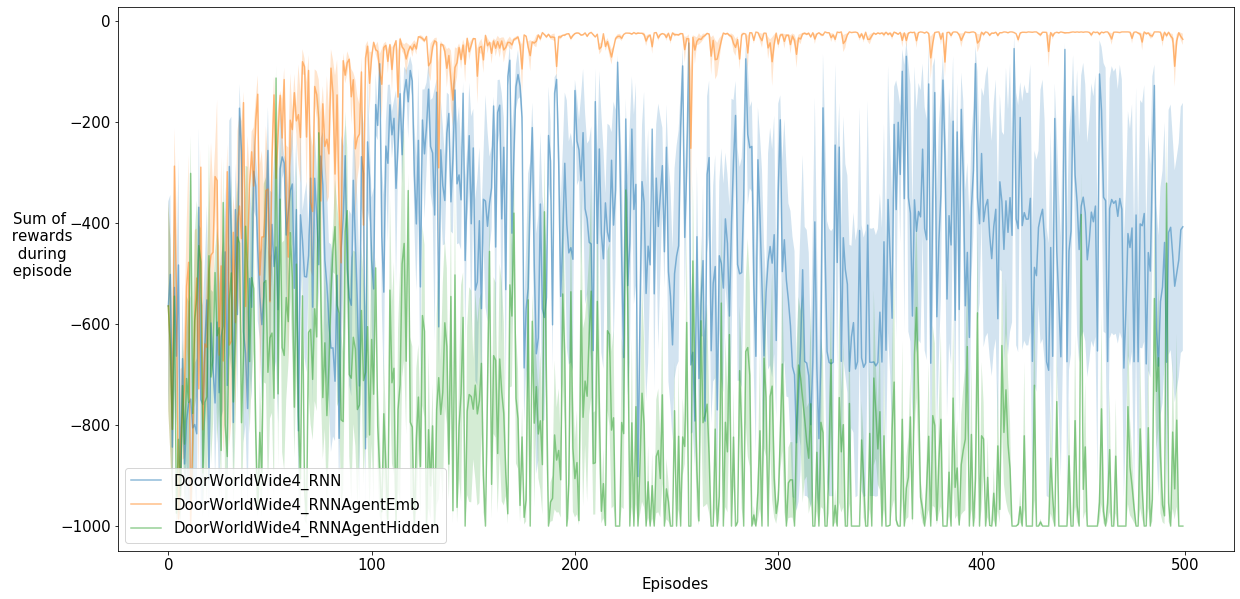

In [53]:
tmp={}
tmp1={'DoorWorldWide10':'DoorWorldWide13X13D2','DoorWorldWide11':'DoorWorldWide13X13D4'}
plt.figure(figsize=(20,10))
for env in env_infos:
    for i, algorithm in enumerate(list(agents.keys())):
        algorithm_means = np.mean(all_reward_sums[env][algorithm], axis=0)
        algorithm_stds = np.std(all_reward_sums[env][algorithm], axis=0)
        plt.plot(algorithm_means, label=tmp1.get(env,env)+'_'+tmp.get(algorithm, algorithm),
                 alpha=0.5)
        plt.fill_between(range(num_episodes), algorithm_means + algorithm_stds/np.sqrt(num_runs), algorithm_means - algorithm_stds/np.sqrt(num_runs), alpha=0.2)
plt.ylabel("Sum of\n rewards\n during\n episode",rotation=0, labelpad=20)
plt.xlabel("Episodes")
# plt.ylim(-500,10)
# plt.plot([0,500],[-24,-24])

plt.legend()
plt.show()


In [85]:
all_reward_sums['DoorWorldWide4']['GRU']

[]

In [46]:
for env in env_infos:
    for algo in agents.keys():
        print(env,algo, np.mean(np.array(all_reward_sums[env][algo])[:,:]),)

DoorWorldWide3 RNN -41.233333333333334
DoorWorldWide3 RNNAgentEmb -37.74466666666667
DoorWorldWide3 RNNAgentHidden -38.808


In [47]:
for env in env_infos:
    for algo in agents.keys():
        print(env,algo, np.mean(np.array(all_reward_sums[env][algo])[:,300:]),)

DoorWorldWide3 RNN -15.966666666666667
DoorWorldWide3 RNNAgentEmb -15.85
DoorWorldWide3 RNNAgentHidden -16.83


In [132]:
for env in env_infos:
    for algo in agents.keys():
        print(env,algo, np.mean(np.array(all_reward_sums[env][algo])[:,:]),)

DoorWorldWide1 NN -410.331
DoorWorldWide1 RNN -471.735
DoorWorldWide1 GRU -109.797
DoorWorldWide2 NN -301.685
DoorWorldWide2 RNN -73.734
DoorWorldWide2 GRU -53.833
DoorWorldWide3 NN -31.132
DoorWorldWide3 RNN -40.411
DoorWorldWide3 GRU -35.956


Rendering 31 frames...


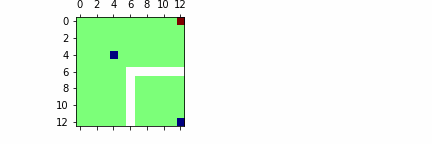

In [150]:
animate(all_history['DoorWorldWide10']['GRU'][-1][-100:])

Rendering 100 frames...


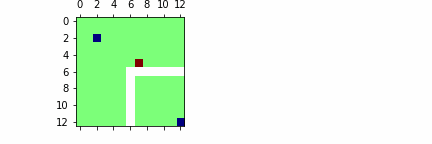

In [152]:
animate(all_history['DoorWorldWide11']['GRU_Trace'][-1][-100:])

Rendering 23 frames...


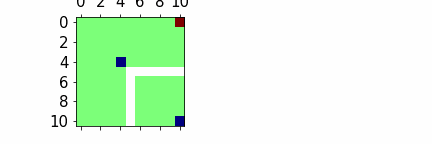

In [55]:
animate(all_history[env]['RNNAgentEmb'][-2][-100:])

Rendering 100 frames...


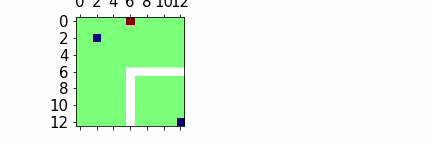

In [112]:
animate(all_history[env]['GRU_Trace'][-1][-100:])

Rendering 31 frames...


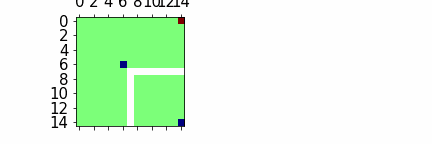

In [102]:
animate(all_history['DoorWorldWide6']['GRU'][-1][-100:])

Rendering 15 frames...


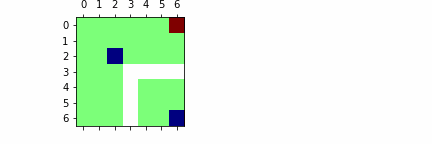

In [137]:
animate(all_history[env]['GRU'][-1][-100:])

Rendering 19 frames...


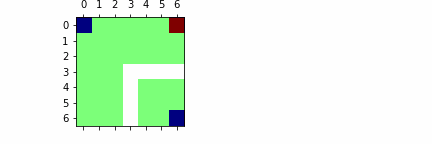

In [138]:
animate(all_history['GRU'][0][-100:])

Rendering 17 frames...


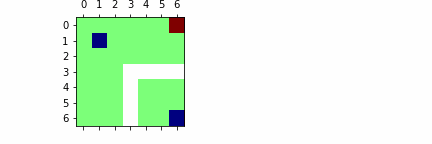

In [142]:
animate(all_history['GRU'][25][-100:])

In [143]:
exp1_reward_sums = all_reward_sums 
exp1_state_visits = all_state_visits

Rendering 100 frames...


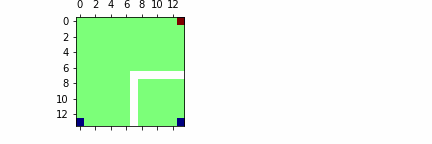

In [166]:
animate(temp[0]['NN'][0][-100:])

In [163]:
temp = list(all_history.values())

In [164]:
temp[0]['NN']

dict_keys(['NN'])

### Test

In [130]:
env = Environment()
env.env_init(env_info)
env.env_start()

(12, False)

In [124]:
import torch

In [125]:
def mask_grid(grid, blocks, mask_value=-100):
   for i in range(grid.shape[0]):
       for j in range(grid.shape[1]):
           if [i,j] in blocks:
               grid[i,j] = mask_value
   grid = np.ma.masked_where(grid == mask_value, grid)
   return grid

In [126]:
hidden = agent.rnn.initHidden()

In [131]:
agent.get_state_feature(env.get_state_features([0,6]))

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0

In [132]:
def get_action_values_matrix(state):
    state = agent.get_state_feature(env.get_state_features(state))
    with torch.no_grad():
        current_q, _ = agent.rnn(state, hidden)
    current_q.squeeze_()
    temp = np.zeros((3,3))
    temp[0,1] = current_q[0]
    temp[1,2] = current_q[1]
    temp[2,1] = current_q[2]
    temp[1,0] = current_q[3]
#     temp[1,1] = current_q[4]
    return temp



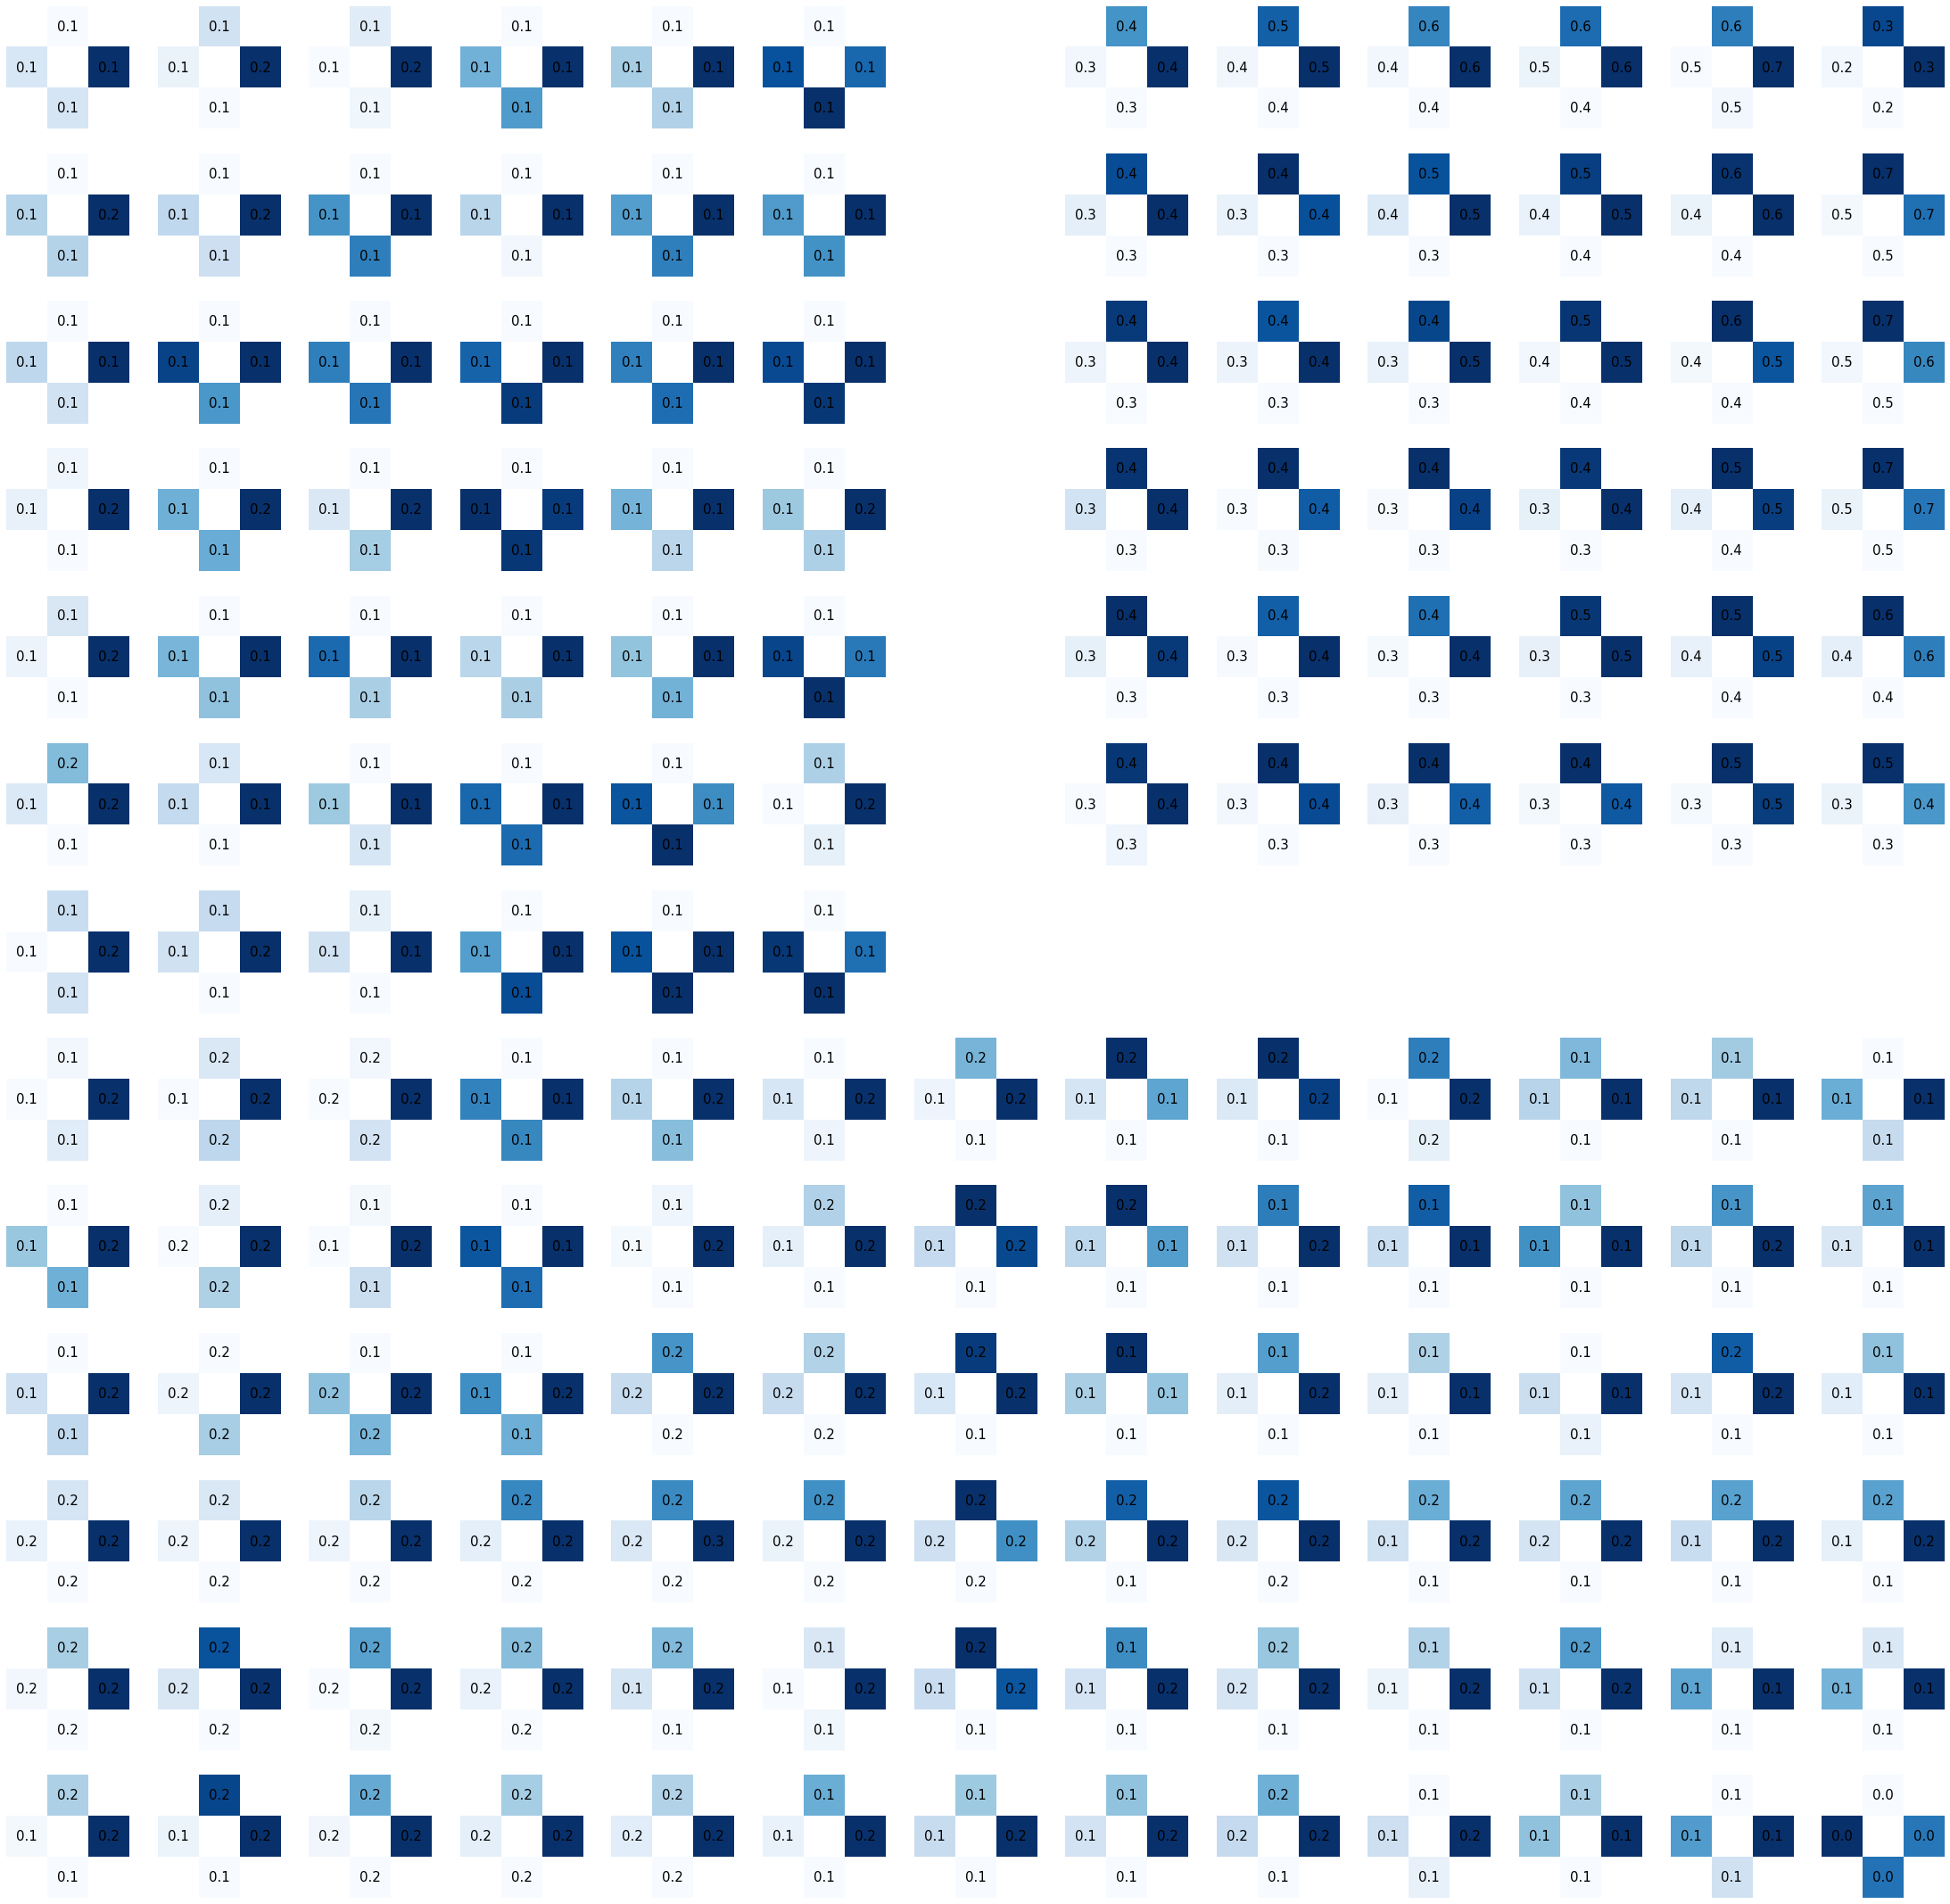

In [133]:
num_row, num_col = env.maze_dim
plt.figure(1, figsize=(num_row*3, num_col*3))
for i,row in enumerate(range(num_row-1,-1,-1)):
# for i,row in enumerate(range(num_row)):
    for col in range(num_col):
        if [row,col] not in env.obstacles:
            ax = plt.subplot(num_row, num_col, i*num_col + col + 1)
            state = [row,col]
            #            state_occupancy_map = mask_grid(np.mean(agent.m[:,state,:],axis=0).reshape(7,7),env.obstacles)
            action_values_map = mask_grid(get_action_values_matrix(state), [[0,0],[1,1],[0,2],[2,0],[2,2]])
            plt.axis('off')
#            ax.imshow(action_values_map,origin='lower',cmap='Greys')
            ax.matshow(action_values_map,cmap='Blues')
#             ax.text(i+0.5, j+0.5, str(c), va='center', ha='center')
#             ax.set_ylim(0,6)
            for (x, y), z in np.ndenumerate(action_values_map):
                if [x, y] not in [[0,0],[1,1],[0,2],[2,0],[2,2]]:
                    ax.text(y, x, '{:0.1f}'.format(z), ha='center', va='center')